<a href="https://colab.research.google.com/github/n-vit/YaP_Projects/blob/main/4_%D0%A1%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Цель проекта
На основе готовой выборки провести анализ доходности тарифов и определить какой из них выгоднее:
- для каждого из тарифов установить среднее количество, дисперсию и стандартное отклонение по объемам потребления категорий:  интернет, звонки, смс. 
- проверить гипотезу о том, что средняя выручка ползователей разных тарифов различается
- проверить гипотезу о том что выручка пользователей из Москвы отличается от других регионов
- дать рекомендации заказчику по итогам исследования по выбору приоритетного тарифа для продвижения

# 1. Общие данные и информация о проекте

**Таблица users (информация о пользователях):**

    user_id — уникальный идентификатор пользователя
    first_name — имя пользователя
    last_name — фамилия пользователя
    age — возраст пользователя (годы)
    reg_date — дата подключения тарифа (день, месяц, год)
    churn_date — дата прекращения пользования тарифом (если значение пропущено,
    то тариф ещё действовал на момент выгрузки данных)
    city — город проживания пользователя
    tarif — название тарифного плана

**Таблица calls (информация о звонках):**

    id — уникальный номер звонка
    call_date — дата звонка
    duration — длительность звонка в минутах
    user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**

    id — уникальный номер сообщения
    message_date — дата сообщения
    user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**

    id — уникальный номер сессии
    mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
    session_date — дата интернет-сессии
    user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**

    tariff_name — название тарифа
    rub_monthly_fee — ежемесячная абонентская плата в рублях
    minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    messages_included — количество сообщений в месяц, включённых в абонентскую плату
    mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

##Описание тарифов
**Тариф «Смарт»**

    Ежемесячная плата: 550 рублей
    Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
    минута разговора: 3 рубля
    сообщение: 3 рубля
    1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**

    Ежемесячная плата: 1950 рублей
    Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
    минута разговора: 1 рубль
    сообщение: 1 рубль
    1 Гб интернет-трафика: 150 рублей

# 2. Обзор и предобработка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import ttest_ind

In [ ]:
try: # if the project is opened in Collab use a 'try' block, if it opened in simulator Yandex, or Jupiter, use an 'except' block
    from google.colab import drive
    drive.mount('/content/drive')
    calls = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/yap5/calls.csv',parse_dates=['call_date'])
    internet = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/yap5/internet.csv', parse_dates=['session_date'])
    messages = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/yap5/messages.csv', parse_dates=['message_date'])
    tariffs = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/yap5/tariffs.csv')
    users = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/yap5/users.csv', parse_dates=['churn_date','reg_date'])

except:
    calls = pd.read_csv('/datasets/calls.csv', parse_dates=['call_date'])
    internet = pd.read_csv('/datasets/internet.csv', parse_dates=['session_date'])
    messages = pd.read_csv('/datasets/messages.csv', parse_dates=['message_date'])
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv', parse_dates=['churn_date','reg_date'])

## 2.1 Информация о пользователях

In [ ]:
display(users.head(5))
display(users.info())
display(users.isna().sum())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


None

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Для дальнейшей работы оптимизируем разрядность и приведем дату в удобный формат.

_я попробовал написать функцию, которая будет понижать разрядность для всех фреймов, но что-то не выходит, поэтому для каждого отдельно_

In [ ]:
'''


def opti_bit(df):
  # this function lowers the bit depth to acceptable values and return optimized dataframe
  df_float = df.select_dtypes(include=['float']) # selecting 'float' data
  df_float = df_float.apply(pd.to_numeric,downcast='float') # lowering the bit depth to acceptable

  df_int = df.select_dtypes(include=['int']) # repeat also for 'int'
  df_int = df_int.apply(pd.to_numeric,downcast='unsigned')

  df[df_int.columns] = df_int # replacing the data in the original frame with optimized ones
  df[df_float.columns] = df_float
  return df
'''


"\n\n\ndef opti_bit(df):\n  # this function lowers the bit depth to acceptable values and return optimized dataframe\n  df_float = df.select_dtypes(include=['float']) # selecting 'float' data\n  df_float = df_float.apply(pd.to_numeric,downcast='float') # lowering the bit depth to acceptable\n\n  df_int = df.select_dtypes(include=['int']) # repeat also for 'int'\n  df_int = df_int.apply(pd.to_numeric,downcast='unsigned')\n\n  df[df_int.columns] = df_int # replacing the data in the original frame with optimized ones\n  df[df_float.columns] = df_float\n  return df\n"

In [ ]:
users_float = users.select_dtypes(include=['float']) # selecting 'float' data
users_float = users_float.apply(pd.to_numeric,downcast='float') # lowering the bit depth to acceptable

users_int = users.select_dtypes(include=['int']) # repeat also for 'int'
users_int = users_int.apply(pd.to_numeric,downcast='unsigned')

users[users_int.columns] = users_int # replacing the data in the original frame with optimized ones
users[users_float.columns] = users_float

#users['reg_date']  = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

users.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    uint16        
 1   age         500 non-null    uint8         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), object(4), uint16(1), uint8(1)
memory usage: 25.0+ KB


## 2.2 Информация о звонках

In [ ]:
display(calls.head(5))
display(calls.info())
display(calls.isna().sum())

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


None

id           0
call_date    0
duration     0
user_id      0
dtype: int64

оптимизируем разрядность и формат даты в файле с информацией о звонках так же, как в предыдущем, округлим длительность звонков до минут и добавим столбец с месяцем

In [ ]:

calls['duration'] = calls.duration.apply(lambda x: math.ceil(x)) #rounding to minutes
#calls['call_date']  = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['month'] = calls['call_date'].dt.month

calls_fl = calls.select_dtypes(include=['float']) 
calls_fl = calls_fl.apply(pd.to_numeric,downcast='float') 

calls_int = calls.select_dtypes(include=['int']) 
calls_int = calls_int.apply(pd.to_numeric,downcast='unsigned')

calls[calls_int.columns] = calls_int 
calls[calls_fl.columns] = calls_fl

calls.head(3) 

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6


Таблица с информацией о звонках готова к дальнейшей работе

## 2.3 Информация об интернет-трафике

In [ ]:
display(internet.head(5))
display(internet.info())
display(internet.isna().sum())

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


None

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

предобработка аналогичная

In [ ]:
#internet['session_date']  = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['month'] = internet['session_date'].dt.month

internet_fl = internet.select_dtypes(include=['float']) 
internet_fl = internet_fl.apply(pd.to_numeric,downcast='float') 

internet_int = internet.select_dtypes(include=['int']) 
internet_int = internet_int.apply(pd.to_numeric,downcast='unsigned')

internet[internet_int.columns] = internet_int 
internet[internet_fl.columns] = internet_fl

internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  uint32        
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float32       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  uint16        
 5   month         149396 non-null  uint8         
dtypes: datetime64[ns](1), float32(1), object(1), uint16(1), uint32(1), uint8(1)
memory usage: 3.8+ MB


## 2.4 Информация о сообщениях

In [ ]:
display(messages.info())

#messages['message_date']  = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['month'] = messages['message_date'].dt.month

messages_int = messages.select_dtypes(include=['int']) 
messages_int = messages_int.apply(pd.to_numeric,downcast='unsigned')

messages[messages_int.columns] = messages_int 
display(messages.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


None

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


## 2.5 Информация о тарифах

In [ ]:
display(tariffs.head(5))
display(tariffs.info())

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

понизим избыточную разрядность и переименуем столбец с названиями тарифов так же как он назван в таблице с пользователями

In [ ]:
tariffs_fl = tariffs.select_dtypes(include=['float']) 
tariffs_fl = tariffs_fl.apply(pd.to_numeric,downcast='float') 

tariffs_int = tariffs.select_dtypes(include=['int']) 
tariffs_int = tariffs_int.apply(pd.to_numeric,downcast='unsigned')

tariffs[tariffs_int.columns] = tariffs_int 
tariffs[tariffs_fl.columns] = tariffs_fl

tariffs = tariffs.rename(columns={'tariff_name':'tariff'})

# 3. Подготовка данных



## 3.1. Сгруппируем данные по звонкам, интернету и трафику по пользователям, и определим среднемесячное потребление услуг связи для каждого пользователя:



In [ ]:
null_mb = internet.query('mb_used == 0')

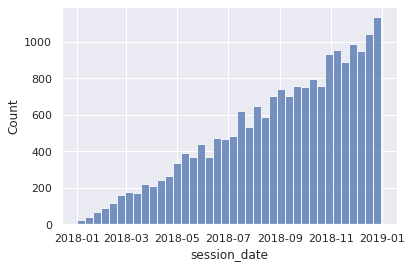

In [ ]:
sns.set(style="darkgrid")
sns.histplot(data=null_mb, x= 'session_date')
plt.show()

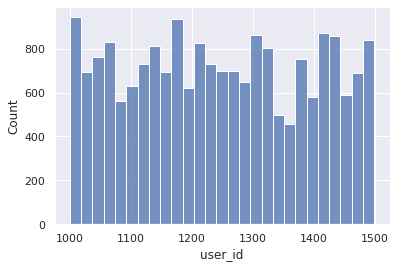

In [ ]:
sns.histplot(data=null_mb, x= 'user_id')
plt.show()

<div class="alert alert-info">
<span style="color:brown"
      
Количество нулевых сессий линейно растет на протяжениии всего времени датасета независимо от пользователей. 
    
Выглядит очень странно, посмотрим в разрезе тарифов

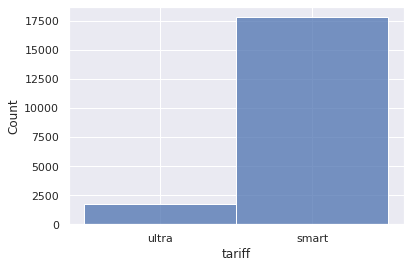

In [ ]:
null_mb = null_mb.merge(users, how='inner', on='user_id')
sns.histplot(data=null_mb, x= 'tariff')
plt.show()

<div class="alert alert-info">
<span style="color:brown"
      
А вот это уже похоже на правду:

На тарифе "Смарт" нулевых сессий гораздо больше, чем на "Ультра". Вероятно, это связано с тем, что **пользователи "Смарта" целиком выбирают предоплаченный пакет интернета, и если на счете нет денег - попытка использования интернет отображается как сессия с нулевым траффиком.**     

In [ ]:
usercalls = calls.groupby(['user_id', 'month']).agg({'duration':'sum'}).reset_index()
usercalls.columns = ['user_id', 'month', 'duration']

usertraffic = internet.groupby(['user_id', 'month']).agg({'mb_used':'sum'}).reset_index()   
usertraffic.columns = ['user_id', 'month', 'mb_used']

usersms = messages.groupby(['user_id', 'month']).agg({'id':'count'}).reset_index()
usersms.columns = ['user_id', 'month', 'sms']

monthly = usercalls.merge(usertraffic, on=['user_id', 'month'], how='outer').merge(usersms, on=['user_id', 'month'], how='outer')

display(monthly.head(5))


,user_id,month,duration,mb_used,sms
0,1000,5,159.0,2253.489990,22.0
1,1000,6,172.0,23233.769531,60.0
2,1000,7,340.0,14003.639648,75.0
3,1000,8,408.0,14055.929688,81.0
4,1000,9,466.0,14568.910156,57.0


## 3.2. Посчитаем ежемесячные затраты каждого пользователя на услуги связи с учетом тарифов и локации

In [ ]:
user_ttl = users.merge(monthly, on='user_id')
user_ttl = user_ttl.drop(columns=['age', 'churn_date', 'first_name', 'last_name', 'reg_date'])

user_ttl = user_ttl.merge(tariffs, on='tariff')
display(user_ttl.head(5))
display(user_ttl.isna().sum())

,user_id,city,tariff,month,duration,mb_used,sms,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,Краснодар,ultra,5,159.0,2253.489990,22.0,1000,30720,3000,1950,150,1,1
1,1000,Краснодар,ultra,6,172.0,23233.769531,60.0,1000,30720,3000,1950,150,1,1
2,1000,Краснодар,ultra,7,340.0,14003.639648,75.0,1000,30720,3000,1950,150,1,1
3,1000,Краснодар,ultra,8,408.0,14055.929688,81.0,1000,30720,3000,1950,150,1,1
4,1000,Краснодар,ultra,9,466.0,14568.910156,57.0,1000,30720,3000,1950,150,1,1


user_id                    0
city                       0
tariff                     0
month                      0
duration                  40
mb_used                   11
sms                      497
messages_included          0
mb_per_month_included      0
minutes_included           0
rub_monthly_fee            0
rub_per_gb                 0
rub_per_message            0
rub_per_minute             0
dtype: int64

У нас есть информация о факте расходования услуг связи и тарифы каждого из пользователей - можно определить среднемесячную выручку оператора от каждого пользователя, появившиеся пропуски в смс и траффике заменим на нулевые значения - эти услуги не использовались

In [ ]:
user_ttl = user_ttl.fillna(0)

user_ttl['user_revenue'] = 0
def revenue(row): 
# takes information about the actual use of services for each user and returns their cost according to the tariff
  user_revenue = row['user_revenue']
  overmin = max(row['duration'] - row['minutes_included'], 0)
  overnet = math.ceil(max(row['mb_used'] - row['mb_per_month_included'], 0)/1024)
  oversms = max(row['sms'] - row['messages_included'], 0)
  user_revenue = (row['rub_monthly_fee'] 
                  + overmin * row['rub_per_minute']
                  + overnet * row['rub_per_gb']
                  + oversms * row['rub_per_message'])
  return user_revenue

user_ttl['user_revenue'] = user_ttl.apply(revenue, axis= 1) 

user_ttl = user_ttl.drop(columns=['messages_included', 'rub_monthly_fee', 'mb_per_month_included', 'minutes_included', 'rub_per_gb', 'rub_per_message', 'rub_per_minute'])

In [ ]:
display(user_ttl.head(5))

,user_id,city,tariff,month,duration,mb_used,sms,user_revenue
0,1000,Краснодар,ultra,5,159.0,2253.489990,22.0,1950.0
1,1000,Краснодар,ultra,6,172.0,23233.769531,60.0,1950.0
2,1000,Краснодар,ultra,7,340.0,14003.639648,75.0,1950.0
3,1000,Краснодар,ultra,8,408.0,14055.929688,81.0,1950.0
4,1000,Краснодар,ultra,9,466.0,14568.910156,57.0,1950.0


теперь все данные для анализа в одной удобной таблице, можно переходить к следующему этапу 


# 4. Анализ данных

4.1 Для каждого из тарифов установим среднее количество, дисперсию и стандартное отклонение по объемам потребления категорий: интернет, звонки, смс

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
user_ttl.pivot_table(index='tariff',
                     values=['duration', 'mb_used', 'sms'],
                     aggfunc=['mean', 'var', 'std'])


mean                        var                              std  \
       duration   mb_used   sms   duration        mb_used      sms duration   
tariff                                                                        
smart    417.93 16,208.39 33.38  36,219.32  34,462,496.00   796.81   190.31   
ultra    526.62 19,468.80 49.36 100,873.63 101,751,016.00 2,285.27   317.61   

                        
         mb_used   sms  
tariff                  
smart   5,870.48 28.23  
ultra  10,087.17 47.80

Пользователи тарифа "Ультра" используют больше услуг, чем пользователи"Смарт"

Дисперсия для всех услуг на тарифе "Ультра" значительно выше, чем на "Смарте", стандартное отклонение "Ультра" примерно вдвое выше чем на "Смарте" и сопоставимо с тарифным пакетом. 

При этом пользователи "Ультра" в среднем вкладываются в тариф, а пользователи "Смарта" в среднем используют больше интернета, чем предусмотрено пакетом

<div class="alert alert-info">
<span style="color:brown"    
      
Хорошо, использую для этого матрицы корреляции: мало кода, гистограммы рядышком, заодно проверим еще раз вывод о нулевых интернет-сесссиях

In [ ]:
ultra = user_ttl.query('tariff == "ultra"')[['duration', 'mb_used', 'sms']]
smart = user_ttl.query('tariff == "smart"')[['duration', 'mb_used', 'sms']]

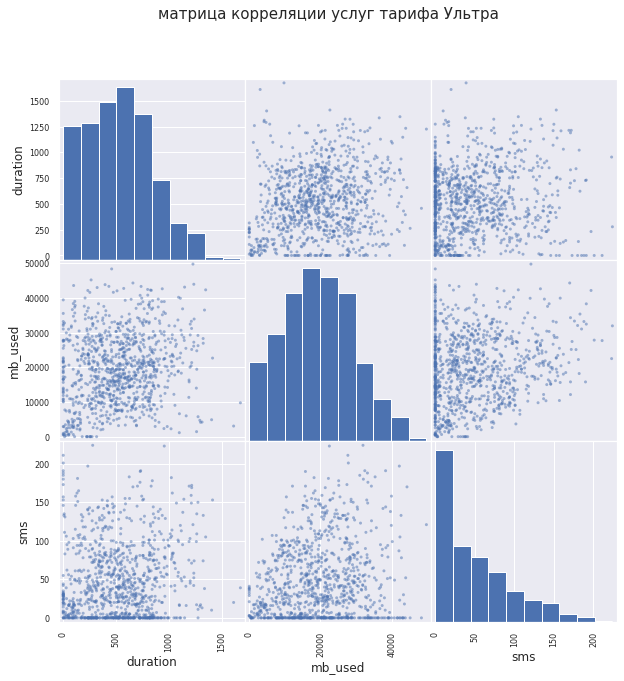

In [ ]:
pd.plotting.scatter_matrix(ultra, figsize=(10, 10)) 
plt.suptitle('матрица корреляции услуг тарифа Ультра', size=15)
plt.show()

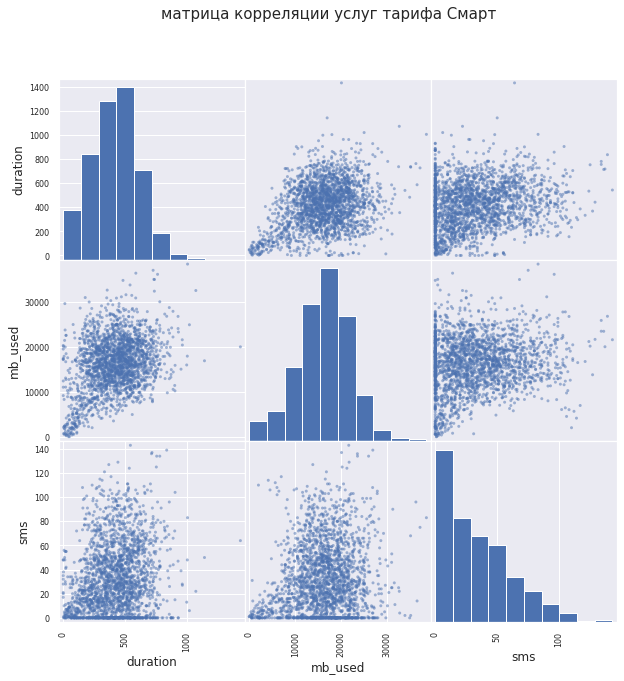

In [ ]:
pd.plotting.scatter_matrix(smart, figsize=(10, 10)) 
plt.suptitle('матрица корреляции услуг тарифа Смарт', size=15)
plt.show()

<div class="alert alert-info">
<span style="color:brown"
      
**Выводы из графиков:**
    
- поведение пользователей Смарт более предсказуемо чем поведение Ультра: на диаграммах рассеяния четко выделяются концентрации точек, а гистограммы Смарт с более высоким колоколом, ближе к нормальному распределению 
- распределение потребления СМС не зависит от тарифа - ими одинаково мало пользуются все пользователи
- Типичные пользователи Смарт и Ультра тратят почти одинаковое количество интернет-трафика - около 20 тыс. Мб, Это значит что пользователи Смарт регулярно доплачивают за сверхлимитный трафик (и это подтверждает наличие в этом тарифе большого количества нулевых сессий, которые отлично видны на диаграммах рассеяния)

    

## 4.2. Проверим гипотезу о том, что средняя выручка пользователей разных тарифов различается
Для этого сформулируем нулевую гипотезу на основе равенства средней выручки в тарифах:

**Нулевая гипотеза**: средняя выручка пользователей тарифов "Ультра" и "Смарт" - равна. 

Если нулевая гипотеза не будет доказана - значит верна альтернативная.

**Альтернативная гипотеза"**: средняя выручка пользователей тарифов "Ультра" и "Смарт" различается

зададим `alpha = 0.05` , что соответствует 5% вероятности ошибки в выводе о принятии нулевой гипотезы

In [ ]:
alpha = 0.05
tstat, pvalue = ttest_ind(user_ttl[user_ttl.tariff == 'ultra'].user_revenue, 
                          user_ttl[user_ttl.tariff == 'smart'].user_revenue,
                          equal_var=False)
print('p-значение =', pvalue)
if pvalue < alpha:
  print('Отвергаем нулевую гипотезу')
else:
  print('Не получилось отвергнуть нулевую гипотезу')

p-значение = 4.2606313931076085e-250
Отвергаем нулевую гипотезу


**ВЫВОД**: Средняя выручка пользователей разных тарифов отличается

## 4.3 Проверим гипотезу о том что выручка пользователей из Москвы отличается от других регионов:
Для этого сформулируем нулевую гипотезу на основе равенства средней выручки для Москвы и остальных:

Нулевая гипотеза: средняя выручка пользователей из Москвы и пользователей из остальных регионов - равна.

Если нулевая гипотеза не будет доказана - значит верна альтернативная.

Альтернативная гипотеза": средняя выручка пользователей из Москвы и других регионов различается

зададим alpha = 0.05 , что соответствует 5% вероятности ошибки в выводе о принятии нулевой гипотезы


In [ ]:
alpha = 0.05
tstat, pvalue = ttest_ind(user_ttl[user_ttl.city == 'Москва'].user_revenue, 
                          user_ttl[user_ttl.tariff != 'Москва'].user_revenue,
                          equal_var=False)
print('p-значение =', pvalue)
if pvalue < alpha:
  print('Отвергаем нулевую гипотезу')
else:
  print('Не получилось отвергнуть нулевую гипотезу')

p-значение = 0.5989670526299276
Не получилось отвергнуть нулевую гипотезу


**ВЫВОД**: Средняя выручка пользователя в Москве такая же как и средняя выручка по остальным регионам

## 4.4 Выбор приоритетного тарифа для продвижения


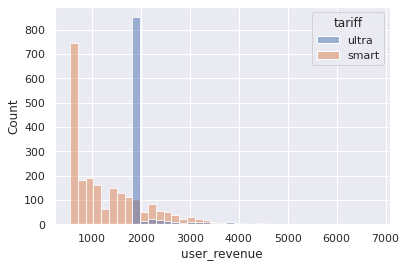

In [ ]:
sns.histplot(data=user_ttl, x='user_revenue', hue='tariff')
plt.show()

Мы выяснили следующие факты относительно тарифов:

- Средняя выручка с клиента в месяц на тарифе "Ультра" выше, чем на "Смарт" на 60%
- Разница в абоненсткой плате тарифов при этом -  почти четырехкратная 
- Большинство пользователей "Ультра" укладываются в тарифные пакеты, а пользователи "Смарт" часто пользуются сверхлимитными услугами
- Большинство пользователей независимо от тарифа укладываются в тарифные пакеты "Ультра", и не укладываются в пакеты "Смарт"

**Из предложенных тарифов выгоднее продвигать "Ультра"**, т.к. средний пользователь независимо от тарифа на этом тарифном плане принесет больше выручки. 


# ВЫВОДЫ:
1. Проведен анализ данных по использованию услуг связи на двух тарифах компании "Мегалайн". Выборка данных является корректной, на ее основе можно делать дальнейшие исследования
2. Выручка пользователей на различных тарифных планах значительно отличается
3. Выручка пользователей не зависит от выбранного региона
Наиболее доходный из предложенных - тарифный план "Ультра"

С точки зрения продвижения предложенных данных недостаточно для выводов:
- нет информации о конкурентном рынке, поэтому выводы можно сделать только допуская что предложенные два тарифа - единственная возможность связи для абонентов. 

- в процессе исследований мы учитывали потребление услуг связи за календарный месяц, без учета начала и окончания договора, предполагая что оба тарифа работали в одинаковых условиях (давно на рынке, не продвигались в период выборки)

- между двумя тарифами значительная разница в абонплате и гораздо меньшая разница в объемах потребления. На рынке с высокой конкуренцией вероятно потребуется промежуточный тариф, разработанный для покупателей с ежемесячными затратами на услуги связи от 800 до 1500 руб, иначе великка вероятность оттока пользователей. На рынке с низкой конкуренцией внедрение третьего тарифа наоборот может привести к потере доходности. 

<div class="alert alert-info">
<span style="color:brown">
    
**Дополнительные выводы:**

Пользователи Смарт регулярно используют сверхлимитный интернет-трафик, увеличив стоимость сверхлимитного трафика на них, можно повысить доходность тарифа смарт, сохранив его визуальную привлекательность. 
    
Для конкурентного рынка сохраняется рекомендация - разработать тариф для промежуточного сегмента покупателей
